## Энергетический оракул
Ноутбук команды #12

Работа выполнена на основе модели LightGBM


### 1. Подготовка данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgb
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

import re

from tqdm import tqdm

from data_preprocess import DataTransformer
random_state = 12345
NUM_ITERATIONS = 5000

In [2]:
# Функция для вычисления метрики mae по дням из почасовых массивов данных

def mae_day(y_true, y_pred):
    y_true_copy = pd.DataFrame(y_true).reset_index(drop=True)
    y_true_copy['day'] = y_true_copy.index // 24
    y_true_grouped = y_true_copy.groupby(by='day').sum()   
    y_pred_copy = pd.DataFrame(y_pred).reset_index(drop=True)
    y_pred_copy['day'] = y_pred_copy.index // 24
    y_pred_grouped = y_pred_copy.groupby(by='day').sum()
    
    return mean_absolute_error(y_true_grouped, y_pred_grouped)
# Функция для вычисления метрик по дням из почасовых массивов данных

def metrics_day(y_true, y_pred):
    y_true_copy = pd.DataFrame(y_true).reset_index(drop=True)
    y_true_copy['day'] = y_true_copy.index // 24
    y_true_grouped = y_true_copy.groupby(by='day').sum()   
    y_pred_copy = pd.DataFrame(y_pred).reset_index(drop=True)
    y_pred_copy['day'] = y_pred_copy.index // 24
    y_pred_grouped = y_pred_copy.groupby(by='day').sum()
    
    mae = mean_absolute_error(y_true_grouped, y_pred_grouped)
    mape = mean_absolute_percentage_error(y_true_grouped, y_pred_grouped)
    r2 = r2_score(y_true_grouped, y_pred_grouped)
    return mae, mape, r2

#### 1.5 Чтение файлов с данными
Данные объединяются в один датасет

In [3]:
transformer = DataTransformer() #инициализируем трансформер

In [4]:
all_ds, test_begin, test_end = transformer.open_file() #оставляем поле пустым что бы использовать открытый датасет

all_ds = transformer.transform(all_ds)

начало открытого теста: 2023-04-01 00:00:00     конец открытого теста: 2023-08-01 00:00:00


#### 1.10 Демонстрация сформированного датасета

In [5]:
# Итоговый набор колонок
all_ds.columns

Index(['date', 'time', 'target', 'temp', 'temp_pred', 'weather_pred',
       'weather_fact', 'cloudy', 'rainy', 'windy', 'clear', 'rain_probability',
       'has_rain_probability', 'holidays', 'preholidays', 'temp_last_day',
       'target_lag_24', 'target_lag_48', 'target_lag_72', 'target_lag_168',
       'target_lag_336', 'VVP', 'P', 'U', 'WW', 'Td', 'N', 'S', 'W', 'E'],
      dtype='object')

In [6]:
all_ds.head()

,date,time,target,temp,temp_pred,weather_pred,weather_fact,cloudy,rainy,windy,...,target_lag_336,VVP,P,U,WW,Td,N,S,W,E
0,2019-01-01,0,481.510,2.9,2.0,"пасм, ветер",ветер,2,0,1,...,0.0,1.8,763.5,100.0,1.0,2.0,1.0,0.0,0.0,0.0
1,2019-01-01,1,462.872,2.9,2.0,"пасм, ветер",ветер,2,0,1,...,0.0,1.8,764.3,93.0,1.0,1.0,1.0,0.0,0.0,0.0
2,2019-01-01,2,449.718,2.9,2.0,"пасм, ветер",ветер,2,0,1,...,0.0,1.8,765.0,93.0,0.0,2.0,1.0,0.0,0.0,0.0
3,2019-01-01,3,430.908,4.3,2.0,"пасм, ветер","ветер, пасм",2,0,1,...,0.0,1.8,765.8,87.0,0.0,1.0,1.0,0.0,0.0,0.0
4,2019-01-01,4,415.163,4.3,2.0,"пасм, ветер","ветер, пасм",2,0,1,...,0.0,1.8,766.6,87.0,0.0,1.0,1.0,0.0,0.0,0.0


#### 1.11 Исключение лишних колонок

In [7]:
# Отбираем признаки. Все лишние колонки здесь отбрасываем, кроме 'date', которую уберем позже 

feature_cols = list(all_ds.columns)

# выбрасываем взгляд в прошлое и расшифрованную погоду
drop_list = ['target', 'weather_pred', 'weather_fact', 'temp']

# выбрасываем признаки, найденные процедурно в процессе оптимизации
# КОМАНДЕ: здесь можно добавлять признаки на выброс с целью оптимизации
drop_list = drop_list + ['target_lag_48', 'target_lag_168', 'target_lag_336',
                        'target_lag_24', 'windy', 'clear',
                        'target_lag_72','has_rain_probability', #'temp_last_day',
                        'N', 'S', 'W', 'E', 'P','U', 'WW', 'Td', 'preholidays',  'cloudy',
 'rainy',
 'rain_probability','temp_pred', 'holidays', 'VVP'] 

for name in drop_list:
    feature_cols.remove(name)

# Итоговый список признаков
feature_cols

['date', 'time', 'temp_last_day']

#### 1.12 Выделение наборов данных для обучения, валидации и тестирования

Выделялось два набора данных для обучения и валидации:
1. Обучение на данных с 2019 по 2021 с валидацией на 2022
2. Обучение на данных с 2019 по 2022 с валидацией на первом квартале 2023

Первый набор позволяет оценить влияние сезонности на обучение и предсказания, второй позволяет обучить модель на большем объеме данных и на более актуальных данных.

In [8]:
# Формируем набор датасетов для обучения и проверки

features = all_ds[feature_cols]
target = all_ds['target']

# Функция для выделения временных интервалов из таблиц признаков и целей
# на этом этапе отбрасываем колонку 'date'
def features_interval(features, target, date1, date2):
    
    features_interval = features[ (features['date']>=date1) & (features['date']<date2) ]
    target_interval = target[features_interval.index]
    

    features_interval.loc[:, 'date'] = pd.to_datetime(features_interval['date'])

    # Преобразование столбца 'time' в timedelta
    features_interval.loc[:, 'time'] = pd.to_timedelta(features_interval['time'], unit='h')

    # Создание нового столбца 'datetime', объединяющего 'date' и 'time'
    features_interval.loc[:, 'datetime'] = features_interval['date'] + features_interval['time']

    # Установка столбца 'datetime' в качестве индекса
    features_interval.set_index('datetime', inplace=True)

    features_interval = features_interval.drop('date', axis=1)
    features_interval = features_interval.drop('time', axis=1)
    target_interval.index = features_interval.index

    return features_interval, target_interval


# для проверки на тестовой выборке будем учиться на всем тренировочном датасете
features_all_train, target_all_train = features_interval(features, target, '2019-01-01', test_begin)
features_open_test, target_open_test = features_interval(features, target, test_begin, test_end )


/var/folders/4y/zccbjjq17fgd73999h5g3ltr0000gn/T/ipykernel_8426/3202848139.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_interval.loc[:, 'date'] = pd.to_datetime(features_interval['date'])
/var/folders/4y/zccbjjq17fgd73999h5g3ltr0000gn/T/ipykernel_8426/3202848139.py:14: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  features_interval.loc[:, 'date'] = pd.to_datetime(features_interval['date'])
/var/folders/4y/zccbjjq17fgd73999h5g3ltr0000gn/T/ipykernel_8426/3202848139.py:17: SettingWithCopyWarning: 
A value is t

In [9]:
features_all_train.head(5)

,temp_last_day
datetime,
2019-01-01 00:00:00,2.0
2019-01-01 01:00:00,2.0
2019-01-01 02:00:00,2.0
2019-01-01 03:00:00,2.0
2019-01-01 04:00:00,2.0


In [10]:
features_open_test.head(5)

,temp_last_day
datetime,
2023-04-01 00:00:00,7.2
2023-04-01 01:00:00,7.2
2023-04-01 02:00:00,7.2
2023-04-01 03:00:00,7.9
2023-04-01 04:00:00,7.9


## AUTO TS

In [11]:
!pip install autots
!pip install scikit-learn
!pip install scipy
!pip install arch
!pip install pytorch-forecasting

!pip install gluonts
!pip install mxnet
!pip install prophet
!pip install statsmodels


In [12]:
!pip install tensorflow

In [13]:
!pip install holidays==0.35

In [14]:
!pip install git+https://github.com/ourownstory/neural_prophet.git

  Cloning https://github.com/ourownstory/neural_prophet.git to /private/var/folders/4y/zccbjjq17fgd73999h5g3ltr0000gn/T/pip-req-build-kmz4g_76
  Running command git clone --filter=blob:none --quiet https://github.com/ourownstory/neural_prophet.git /private/var/folders/4y/zccbjjq17fgd73999h5g3ltr0000gn/T/pip-req-build-kmz4g_76
  Resolved https://github.com/ourownstory/neural_prophet.git to commit f08dcf814034527577abe21ad0bdf28e27d4eb66
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [15]:
!pip install torch==2.0.0


In [16]:
from autots import AutoTS, load_daily, load_hourly
from autots.models.model_list import model_lists
import tensorflow as tf


In [17]:
!pip install pytorch-lightning==1.9.4

In [18]:
!pip install torchvision==0.15

In [19]:
from pytorch_lightning.core.module import LightningModule


In [20]:
!pip install gluonts

from sklearn.metrics import pairwise
#import neuralprophet
import scipy
from arch import arch_model
import pytorch_forecasting 
from neuralprophet import NeuralProphet
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler
import gluonts.model
from prophet import Prophet
import statsmodels.api as sm

In [21]:
print(model_lists.keys())

dict_keys(['all', 'default', 'fast', 'superfast', 'parallel', 'fast_parallel', 'fast_parallel_no_arima', 'probabilistic', 'multivariate', 'univariate', 'no_params', 'recombination_approved', 'no_shared', 'no_shared_fast', 'experimental', 'slow', 'gpu', 'regressor', 'best', 'motifs', 'all_result_path', 'regressions', 'all_pragmatic', 'update_fit'])


In [22]:
df_train_autots = pd.concat([target_all_train, features_all_train ], axis=1)

In [23]:
df_test_autots = pd.concat([target_open_test, features_open_test ], axis=1)
df_test_autots.head(3)

,target,temp_last_day
datetime,,
2023-04-01 00:00:00,479.282,7.2
2023-04-01 01:00:00,445.182,7.2
2023-04-01 02:00:00,424.225,7.2


In [24]:
print(model_lists['fast'])

{'ConstantNaive': 1, 'LastValueNaive': 1.5, 'AverageValueNaive': 1, 'GLS': 1, 'SeasonalNaive': 1, 'GLM': 1, 'ETS': 1, 'VAR': 0.8, 'VECM': 1, 'WindowRegression': 0.5, 'DatepartRegression': 0.8, 'UnivariateMotif': 1, 'MultivariateMotif': 0.8, 'SectionalMotif': 1, 'NVAR': 1, 'MAR': 1, 'RRVAR': 1, 'KalmanStateSpace': 1, 'MetricMotif': 1, 'Cassandra': 1, 'SeasonalityMotif': 1}


In [25]:
model_lists['regressor']

['GLM',
 'ARIMA',
 'FBProphet',
 'RollingRegression',
 'UnobservedComponents',
 'VECM',
 'DynamicFactor',
 'WindowRegression',
 'VAR',
 'DatepartRegression',
 'GluonTS',
 'UnivariateRegression',
 'MultivariateRegression',
 'SectionalMotif',
 'ARDL',
 'NeuralProphet',
 'ARCH',
 'Cassandra',
 'PreprocessingRegression']

In [26]:
model_list = model_lists['regressor']
drop_models = ['WindowRegression']
for name in drop_models:
    model_list.remove(name)
model_list

['GLM',
 'ARIMA',
 'FBProphet',
 'RollingRegression',
 'UnobservedComponents',
 'VECM',
 'DynamicFactor',
 'VAR',
 'DatepartRegression',
 'GluonTS',
 'UnivariateRegression',
 'MultivariateRegression',
 'SectionalMotif',
 'ARDL',
 'NeuralProphet',
 'ARCH',
 'Cassandra',
 'PreprocessingRegression']

In [27]:
model_list_2 = model_lists['fast']


model_list_2 = ['ARIMA', 'NeuralProphet', 'DatepartRegression','FBProphet' , 'Cassandra', 'GLM'] 
model_list_2 = ['ARIMA', 'FBProphet'] 


In [51]:
metric_weighting = {
    'mae_weighting': 5,
    'mape_weighting': 3,
    'rmse_weighting': 2,
#    'made_weighting': 0.5,
#    'mage_weighting': 1,
#    'mle_weighting': 0,
    'imle_weighting': 0,
#    'spl_weighting': 3,
    'containment_weighting': 0,
    'contour_weighting': 1,
    'runtime_weighting': 0.05,
}
model = AutoTS(
    forecast_length=24,
    frequency='infer',
    prediction_interval=0.9,
    ensemble='simple',
    model_list="regressor", #model_list_2,  "superfast", "default", "fast_parallel", 'fast'
    transformer_list="fast",  # "superfast",
    metric_weighting=metric_weighting,
    drop_most_recent=1,
    max_generations=2,
    n_jobs='auto',
    num_validations=4,
    validation_method="backwards"
)

Using 7 cpus for n_jobs.


In [52]:
model = model.import_template(
    "auto_ts_model.csv",
    method="only",
    enforce_model_list=True)

In [53]:
print("Overwrite template is: {}".format(str(model.initial_template)))

Overwrite template is:                                  ID Model  \
5  ff2cc3abb24d54d70d5baf7596d16148   VAR   
6  f8628013aa1db35c5718b8c83863954f   VAR   
7  4406dc002d51e949515c8b95afd439f8   VAR   

                                     ModelParameters  \
5  {"regression_type": null, "maxlags": null, "ic...   
6  {"regression_type": null, "maxlags": null, "ic...   
7  {"regression_type": null, "maxlags": null, "ic...   

                            TransformationParameters  Ensemble  
5  {"fillna": "ffill", "transformations": {"0": "...         0  
6  {"fillna": "ffill", "transformations": {"0": "...         0  
7  {"fillna": "ffill", "transformations": {"0": "...         0  


In [54]:

model = model.fit(
    df_train_autots,
    weights={'target': 1}
)

Data frequency is: H, used frequency is: H
Model Number: 1 with model VAR in generation 0 of 2
Model Number: 2 with model VAR in generation 0 of 2
Model Number: 3 with model VAR in generation 0 of 2
New Generation: 1 of 2
Model Number: 4 with model VAR in generation 1 of 2
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 4 in generation 1: VAR
Model Number: 5 with model VAR in generation 1 of 2
Model Number: 6 with model VAR in generation 1 of 2
Model Number: 7 with model VAR in generation 1 of 2
Model Number: 8 with model VAR in generation 1 of 2
New Generation: 2 of 2
Model Number: 9 with model VAR in generation 2 of 2
Model Number: 10 with model VAR in generation 2 of 2
Model Number: 11 with model VAR in generation 2 of 2
Model Number: 12 with model VAR in generation 2 of 2
Model Number: 13 with model VAR in generation 2 of 2
Model Number: 14 with model VAR in generation 2 of 2
Model Number: 15 with model VAR in generation 2 of 2
Model Number: 

/opt/anaconda3/lib/python3.9/site-packages/autots/models/ensemble.py:1021: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  cur_mods = pd.Series(models_pos).value_counts()
/opt/anaconda3/lib/python3.9/site-packages/autots/models/ensemble.py:1021: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  cur_mods = pd.Series(models_pos).value_counts()


Model Number: 18 with model Ensemble in generation 3 of Ensembles
Model Number: 19 with model Ensemble in generation 3 of Ensembles
Model Number: 20 with model Ensemble in generation 3 of Ensembles
Model Number: 21 with model Ensemble in generation 3 of Ensembles
Model Number: 22 with model Ensemble in generation 3 of Ensembles
Validation Round: 1
Model Number: 1 of 4 with model Ensemble for Validation 1
📈 1 - Ensemble with avg smape 56.36: 
Model Number: 2 of 4 with model VAR for Validation 1
2 - VAR with avg smape 56.36: 
Model Number: 3 of 4 with model Ensemble for Validation 1
📈 3 - Ensemble with avg smape 50.85: 
Model Number: 4 of 4 with model VAR for Validation 1
📈 4 - VAR with avg smape 48.29: 
Validation Round: 2
Model Number: 1 of 4 with model Ensemble for Validation 2
📈 1 - Ensemble with avg smape 66.51: 
Model Number: 2 of 4 with model VAR for Validation 2
2 - VAR with avg smape 66.51: 
Model Number: 3 of 4 with model Ensemble for Validation 2
📈 3 - Ensemble with avg smape 

/opt/anaconda3/lib/python3.9/site-packages/autots/models/ensemble.py:1021: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  cur_mods = pd.Series(models_pos).value_counts()


Model Number: 40 with model Ensemble in generation 4 of Ensembles
Model Number: 41 with model Ensemble in generation 4 of Ensembles
Model Number: 42 with model Ensemble in generation 4 of Ensembles
Model Number: 43 with model Ensemble in generation 4 of Ensembles
Validation Round: 1
Model Number: 1 of 5 with model Ensemble for Validation 1
📈 1 - Ensemble with avg smape 51.7: 
Model Number: 2 of 5 with model Ensemble for Validation 1
2 - Ensemble with avg smape 53.51: 
Model Number: 3 of 5 with model Ensemble for Validation 1
3 - Ensemble with avg smape 51.7: 
Model Number: 4 of 5 with model Ensemble for Validation 1
4 - Ensemble with avg smape 53.51: 
Model Number: 5 of 5 with model Ensemble for Validation 1
📈 5 - Ensemble with avg smape 49.55: 
Validation Round: 2
Model Number: 1 of 5 with model Ensemble for Validation 2
📈 1 - Ensemble with avg smape 64.93: 
Model Number: 2 of 5 with model Ensemble for Validation 2
2 - Ensemble with avg smape 65.56: 
Model Number: 3 of 5 with model En

In [55]:
df_train_autots.head()

,target,temp_last_day
datetime,,
2019-01-01 00:00:00,481.510,2.0
2019-01-01 01:00:00,462.872,2.0
2019-01-01 02:00:00,449.718,2.0
2019-01-01 03:00:00,430.908,2.0
2019-01-01 04:00:00,415.163,2.0


In [56]:
# accuracy of all tried model results
model_results = model.results()
# and aggregated from cross validation
validation_results = model.results("validation")

In [62]:
validation_results.sort_values('mae', ascending=True).head(5) #.to_csv('result_val_auto_ts_2.csv')

,ID,Model,ModelParameters,TransformationParameters,Ensemble,Runs,smape,mae,rmse,made,...,uwmse_weighted,smoothness_weighted,containment_weighted,contour_weighted,TotalRuntimeSeconds,Score,lowest_series_mape,lowest_series_mape_name,highest_series_mape,highest_series_mape_name
23,f3035e0300b9178581961346047fe978,Ensemble,"{""model_name"": ""BestN"", ""model_count"": 5, ""mod...",{},1,1,21.719795,3.687344,4.544568,0.553551,...,11.884371,1.568126,1.000,0.833333,20.0575,10.134145,1.015392,target,28.097873,temp_last_day
5,53f16d99b1f5308605f49aef96c09f14,VAR,"{""regression_type"": null, ""maxlags"": null, ""ic...","{""fillna"": ""akima"", ""transformations"": {""0"": ""...",0,1,21.906515,3.708804,4.597325,0.577447,...,12.190482,1.571927,1.000,0.833333,1.9146,10.169353,1.021113,target,28.271775,temp_last_day
13,8b828327629f66849fceb6fe093df948,Ensemble,"{""model_name"": ""BestN"", ""model_count"": 5, ""mod...",{},1,1,23.625332,3.712933,4.616690,0.588079,...,13.334159,1.573146,1.000,0.875000,24.3574,10.106605,0.980378,target,30.614017,temp_last_day
3,4406dc002d51e949515c8b95afd439f8,VAR,"{""regression_type"": null, ""maxlags"": null, ""ic...","{""fillna"": ""ffill"", ""transformations"": {""0"": ""...",0,1,23.866112,3.770243,4.660874,0.872286,...,14.618266,1.230846,0.875,0.750000,43.4381,10.527373,0.990169,target,31.381303,temp_last_day
25,ff2cc3abb24d54d70d5baf7596d16148,VAR,"{""regression_type"": null, ""maxlags"": null, ""ic...","{""fillna"": ""ffill"", ""transformations"": {""0"": ""...",0,1,24.062389,3.802292,4.682446,0.588893,...,13.564305,1.563342,1.000,0.875000,6.3492,10.242262,1.011339,target,30.944278,temp_last_day


In [64]:
print(model)

Initiated AutoTS object with best model: 
Ensemble
{}
{'model_name': 'BestN', 'model_count': 3, 'model_metric': 'best_score', 'models': {'0e67dd0b6c295b24bd2fa8a9f29667f3': {'Model': 'Ensemble', 'ModelParameters': '{"model_name": "BestN", "model_count": 3, "model_metric": "best_score_unique", "models": {"f8628013aa1db35c5718b8c83863954f": {"Model": "VAR", "ModelParameters": "{\\"regression_type\\": null, \\"maxlags\\": null, \\"ic\\": \\"fpe\\"}", "TransformationParameters": "{\\"fillna\\": \\"ffill\\", \\"transformations\\": {\\"0\\": \\"StandardScaler\\"}, \\"transformation_params\\": {\\"0\\": {}}}"}, "478b18bb54150fa061275883488f502f": {"Model": "SeasonalNaive", "ModelParameters": "{\\"method\\": \\"lastvalue\\", \\"lag_1\\": 24, \\"lag_2\\": 168}", "TransformationParameters": "{\\"fillna\\": \\"ffill\\", \\"transformations\\": {\\"0\\": \\"SeasonalDifference\\"}, \\"transformation_params\\": {\\"0\\": {\\"lag_1\\": 12, \\"method\\": \\"Median\\"}}}"}, "91bb392160e78b8d0b539c52c99f

In [59]:
import joblib
joblib.dump(model, 'Autots_regr_temp_target_4.pkl')


['Autots_regr_temp_target_4.pkl']

In [63]:
from joblib import load

# Загрузка модели из файла
model = load('Autots_regr_temp_target.pkl')

<Axes: title={'center': 'target with model BestN'}>

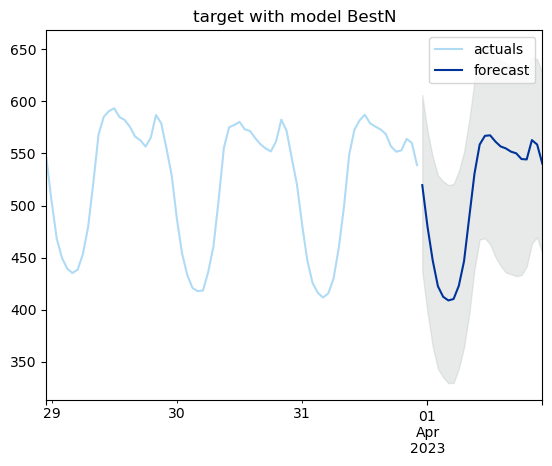

In [66]:
prediction = model.predict()
# plot a sample
prediction.plot(model.df_wide_numeric,
                series=model.df_wide_numeric.columns[0],
                )

<Axes: title={'center': 'Validation Forecasts for target'}, xlabel='datetime'>

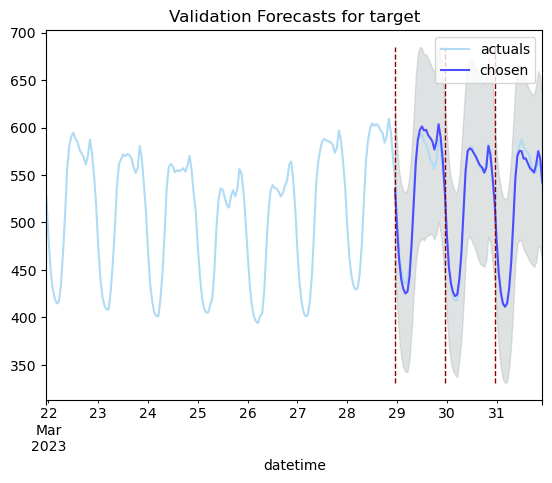

In [65]:
model.plot_validations()

In [67]:
out = prediction.forecast()
out

,target,temp_last_day
2023-03-31 23:00:00,519.604960,6.660398
2023-04-01 00:00:00,479.911717,6.016058
2023-04-01 01:00:00,447.359582,6.012799
2023-04-01 02:00:00,422.525141,6.057933
2023-04-01 03:00:00,412.443608,5.270588
2023-04-01 04:00:00,408.923160,5.283100
2023-04-01 05:00:00,410.306218,5.277429
2023-04-01 06:00:00,422.944858,5.996313
2023-04-01 07:00:00,446.591419,6.011193
2023-04-01 08:00:00,488.826871,6.217602


In [ ]:
daily_data = df_test_autots.resample('D').apply(lambda x: x)

In [ ]:
daily_data.head(48)

In [ ]:
df_test_autots['date'] = df_test_autots.index.date

for temp_train in df_test_autots:
    
    #print(temp_train.head(5))
    model = model.fit(
    temp_train,
    
    weights={'target': 20} 
)
    pred = model.predict()
    out = pred.forecast

In [ ]:
df_test_autots.drop(columns='date')
df_test_autots.head()

In [ ]:
        model = model.fit(
            temp_train,
            
            weights={'target': 20} 
        )
        pred = model.predict()
        out = pred.forecast

In [ ]:
res_df = pd.DataFrame()
res_df = pd.concat([res_df, out])
df_test_autots['date'] = df_test_autots.index.date

for date, df in df_test_autots.groupby('date'):
    temp_train = df.drop(columns='date')
    
    
    
    try:
        model = model.fit(
            temp_train,
            
            weights={'target': 20} 
        )
        pred = model.predict()
        out = pred.forecast
    
        if out['target'].isnull().sum() != 0:
            print('Missing forecast ', date)
        
    except:
        print('Did not execute ', date)
    res_df = pd.concat([res_df, out])

In [ ]:
auto_ts_model = "auto_ts_model.csv"  # .csv/.json
model.export_template(auto_ts_model, models='best',
                      n=15, max_per_model_class=3)

In [ ]:
auto_ts_model = "auto_ts_model.json"  # .csv/.json
model.export_template(auto_ts_model, models='best',
                      n=15, max_per_model_class=3)

In [ ]:
print(model.best_model_name)

In [ ]:
print(model.best_model_params)

In [ ]:

print(model.best_model_transformation_params)

### on new training
model = AutoTS(forecast_length=forecast_length,
               frequency='infer', max_generations=0,
               num_validations=0, verbose=0)
model = model.import_template(example_filename, method='only') # method='add on'
print("Overwrite template is: {}".format(str(model.initial_template)))


In [ ]:
# Рисуем графическое представление предсказания на 2022 год

y_true_copy = pd.DataFrame(target_valid).reset_index(drop=True)
y_true_copy['day'] = y_true_copy.index // 24
y_true_grouped = y_true_copy.groupby(by='day').sum()   
y_true_grouped
y_pred_copy = pd.DataFrame(y_pred).reset_index(drop=True)
y_pred_copy['day'] = y_pred_copy.index // 24
y_pred_grouped = y_pred_copy.groupby(by='day').sum()

#pd.DataFrame(date_valid)
tmpdf = pd.DataFrame(train_ds.loc[features_valid.index,:]['date']).groupby(by='date').count().reset_index().join(y_true_grouped)
tmpdf.plot(x='date', y='target', figsize=(18,5))
ax=plt.gca()
tmpdf = pd.DataFrame(train_ds.loc[features_valid.index,:]['date']).groupby(by='date').count().reset_index().join(y_pred_grouped)
tmpdf.plot(ax=ax, x='date', y=0)

In [ ]:
# Предсказываем той же моделью (19-21) тренировочный кусок 2023 (первый квартал)
mae = mae_day(target_2023, lgbm_model.predict(features_2023))
print(f'mae = {mae}')